# QITE - Evaluation

- **RQ1: Bug detection**. How effective is QITE at finding bugs in quantum computing platforms?
- **RQ2: Impact of ITE iterations**. What is the impact of the number of ITE iterations on the diversity, coverage of generated programs and on the number of detected crashes and inconsistencies?
- **RQ3: Comparison with prior work**. How does QITE perform in comparison to a state-of-the-art metamorphic testing technique for quantum platforms MorphQ?
- **RQ4: Efficiency**. How efficient is QITE in terms of program generation and analysis?

In [32]:
from typing import List, Tuple, Dict, Any, Optional, Union, Set
from multiprocessing import Pool
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path
from dataclasses import dataclass, field
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Configuration and Utility Functions

In [ ]:

# QITE Runs for RQ2, RQ3, RQ4

EXPERIMENTS_QITE = {
    # program_bank/v048/2025_03_11__23_22_3d489d
    "2025_03_11__23_22_3d489d": {
        "path": "../program_bank/v048/2025_03_11__23_22_3d489d",
        "description": "1000 programs - RQs: ITE iterations (RQ2) and efficiency (RQ4)"
    },
    # program_bank/v048/2025_03_11__23_22_7c755e
    "2025_03_11__23_22_7c755e": {
        "path": "../program_bank/v048/2025_03_11__23_22_7c755e",
        "description": "1000 programs - RQs: ITE iterations (RQ2) and efficiency (RQ4)"
    },
    # program_bank/v048/2025_03_11__23_22_38ce99
    "2025_03_11__23_22_38ce99": {
        "path": "../program_bank/v048/2025_03_11__23_22_38ce99",
        "description": "1000 programs - RQs: ITE iterations (RQ2) and efficiency (RQ4)"
    },
    # program_bank/v048/2025_03_11__23_22_96bacf
    "2025_03_11__23_22_96bacf": {
        "path": "../program_bank/v048/2025_03_11__23_22_96bacf",
        "description": "1000 programs - RQs: ITE iterations (RQ2) and efficiency (RQ4)"
    },
    # program_bank/v048/2025_03_11__23_22_afbb03
    "2025_03_11__23_22_afbb03": {
        "path": "../program_bank/v048/2025_03_11__23_22_afbb03",
        "description": "1000 programs - RQs: ITE iterations (RQ2) and efficiency (RQ4)"
    },
    # program_bank/v049/2025_03_12__01_31_bbcb5d
    "2025_03_12__01_31_bbcb5d": {
        "path": "../program_bank/v049/2025_03_12__01_31_bbcb5d",
        "description": "1h - RQ: Comparison of QITE and MorphQ"
    },
}
# add provenance field to the data
EXPERIMENTS_QITE = {
    k: {**v, "provenance": "qite"} for k, v in EXPERIMENTS_QITE.items()
}

EXPERIMENTS_COVERAGE = [
    # coverage + comparator each round
    "2025_03_11__23_22_3d489d",
    "2025_03_11__23_22_7c755e",
    "2025_03_11__23_22_38ce99",
    "2025_03_11__23_22_96bacf",
    "2025_03_11__23_22_afbb03",

]
N_INITIAL_PROGRAMS = 1000


# MorphQ Runs for RQ3

EXPERIMENTS_MORPHQ = {
    "v26": {
        "path": "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v26",
        "description": "MorphQ Data - 1h - RQ: Comparison of QITE and MorphQ"
    }
}
# add provenance field to the data
EXPERIMENTS_MORPHQ = {
    k: {**v, "provenance": "morphq"} for k, v in EXPERIMENTS_MORPHQ.items()
}


EXPERIMENTS_ALL = {
    **EXPERIMENTS_MORPHQ,
    **EXPERIMENTS_QITE
}
SELECTED_EXP_QITE = "2025_03_12__01_31_bbcb5d"
SELECTED_EXP_MORPHQ = "v26"

PLATFORMS = [
    'qiskit', 'pennylane', 'pytket',
    # 'bqskit'
]

# Reported bugs for RQ1
PATH_BUGS = "../reports/bugs_v001.csv"

In [6]:
from multiprocessing import Pool
import re


def get_comparison_folder_name(base_path: str) -> str:
    """Get the comparison folder name based on the highest integer suffix."""
    comparison_folders = [f for f in os.listdir(
        base_path) if f.startswith("comparison")]
    if len(comparison_folders) == 1:
        return comparison_folders[0]
    else:
        comparison_folders = sorted(
            comparison_folders, key=lambda x: int(x.split('_')[-1]))
        return comparison_folders[-1]


def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["_filename"] = os.path.basename(file_path)
        return data


def read_all_jsons(dir_path: str) -> pd.DataFrame:
    json_files = [os.path.join(dir_path, f) for f in os.listdir(
        dir_path) if re.match(r'.*\.json$', f)]
    records = []

    with Pool() as pool:
        results = pool.map(read_json_file, json_files)
        records.extend(results)

    return pd.DataFrame(records)

# RQ1: Bug Detection

In [ ]:
import re


def format_code_blocks(text: str) -> str:
    """Replace backticked text with LaTeX code environment."""
    if not isinstance(text, str):
        return text
    return re.sub(r'`([^`]+)`', r'\\code{\1}', text)


def generate_latex_macro_name(text: str) -> str:
    """Generate a camel case LaTeX macro name from the input text."""
    text = text.replace("\code{", "").replace("}", "")  # Remove code blocks
    words = re.findall(r'\b\w+\b', text)  # Extract words
    words = [re.sub(r'\d+', '', word) for word in words]  # Remove digits
    words = [re.sub(r'[^\w\s]', '', word)
             for word in words]  # Remove punctuation
    # Lowercase and remove empty strings
    words = [word.lower() for word in words if word]

    selected_words = words[:5] if len(words) >= 4 else words[:3]
    camel_case = ''.join(word.capitalize() for word in words)
    # Use first 4-5 letters if available, otherwise 3
    return camel_case


def transform_triggerable(value: str) -> str:
    """Convert yes/no string to LaTeX tick/cross mark."""
    return r"\ding{51}" if value.startswith("yes") else r"\faGear"


def prepare_bugs_dataframe(
        df: pd.DataFrame, anonymize: bool = True) -> pd.DataFrame:
    """Transform bugs data for LaTeX output."""
    # Drop unnecessary columns
    df = df.drop(columns=[
        'crash_msg',
        'substr_crash_msg'
    ])
    df["github_link"] = "\\#XXXX"
    # Apply transformations
    if not "triggerable" in df.columns:
        df = df.rename(columns={"is_still_triggerable": "triggerable"})
    df["triggerable"] = df["triggerable"].apply(transform_triggerable)
    df.drop("triggerable", axis=1, inplace=True)
    df["short_desc"] = df["short_desc"].apply(format_code_blocks)

    # Generate LaTeX commands
    for i, row in df.iterrows():
        print(
            f"\\newcommand{{\\IdBug" +
            generate_latex_macro_name(row['short_desc']) + "}{" + str(i + 1) + "}")

    # Format column names
    df.columns = df.columns.str.replace("_", " ").str.title()
    # Adjust index to start from 1
    df.index += 1
    return df


def print_stats_issues(df_bugs: pd.DataFrame) -> None:
    """Print statistics about bug issues."""
    total = len(df_bugs)
    confirmed = len(df_bugs[df_bugs['status'] == 'Confirmed'])
    fixed = len(df_bugs[df_bugs['status'] == 'Fixed'])
    reported = len(df_bugs[df_bugs['status'] == 'Reported'])

    print(f"\\newcommand{{\\TotalConfirmedBugs}}{{{confirmed}}}")
    print(
        f"\\newcommand{{\\TotalConfirmedOrFixedBugs}}{{{confirmed + fixed}}}")
    print(f"\\newcommand{{\\TotalFixedBugs}}{{{fixed}}}")
    print(f"\\newcommand{{\\TotalReportedBugs}}{{{reported}}}")
    print(f"\\newcommand{{\\TotalAllBugs}}{{{total}}}")

    tot_changing_configuration = len(
        df_bugs[df_bugs['is_still_triggerable'] == 'changing_configuration'])
    print(
        f"\\newcommand{{\\TotalChangingConfiguration}}{{{tot_changing_configuration}}}")


df_bugs = pd.read_csv(PATH_BUGS)
df_bugs["platform"] = df_bugs["platform"].apply(
    lambda x: x.replace("TKET", "Pytket"))
# remove those that have "is_still_triggerable" == "no_because_of_generator"
df_bugs = df_bugs[df_bugs["is_still_triggerable"] != "no_because_of_generator"]
# map those that have "is_still_triggerable" == "no_because_of_workaround" or
# start with "yes_if" to "changing_configuration"
df_bugs["is_still_triggerable"] = df_bugs["is_still_triggerable"].apply(
    lambda x: "changing_configuration"
    if x.startswith("yes_if_") or x == "no_because_of_workaround" else x)
df_bugs.reset_index(drop=True, inplace=True)
print_stats_issues(df_bugs)
# Anonymous github issue
df_bugs = prepare_bugs_dataframe(df_bugs, anonymize=True)

# Print LaTeX table
print(df_bugs.to_latex(index=True))

\newcommand{\TotalConfirmedBugs}{8}
\newcommand{\TotalConfirmedOrFixedBugs}{14}
\newcommand{\TotalFixedBugs}{6}
\newcommand{\TotalReportedBugs}{3}
\newcommand{\TotalAllBugs}{17}
\newcommand{\TotalChangingConfiguration}{5}
\newcommand{\IdBugUnexpectedReallocationOfGatesToDifferentQubits}{1}
\newcommand{\IdBugMissingStandardRxxGateDefinition}{2}
\newcommand{\IdBugUnrecognizedDelayGate}{3}
\newcommand{\IdBugErrorConvertingDecomposedCircuitPhasedxOp}{4}
\newcommand{\IdBugMissingControlledPhaseCsGateDefinition}{5}
\newcommand{\IdBugErrorExportingQasmFileMidmeasurempOp}{6}
\newcommand{\IdBugUnitaryMatrixMismatchInCuGateImplementation}{7}
\newcommand{\IdBugIncompatOfPhasedxGateWithGreedypaulisimpOpt}{8}
\newcommand{\IdBugUnsupportedIswapGate}{9}
\newcommand{\IdBugZxgraphlikeoptPassCreateNotEquivalentCircuit}{10}
\newcommand{\IdBugFullpeepholeoptPassFailsWithMcrzGate}{11}
\newcommand{\IdBugIncorrectMcxGateGenerationCxInsteadOfCx}{12}
\newcommand{\IdBugIncorrectUGateConversionToU}{13}
\newcomma

# RQ2: Impact of Number of ITE Iterations

In [ ]:
def read_metadata_file(file_path: str) -> Dict[str, Any]:
    """Load metadata from JSON file and add filepath information."""
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        data['filepath'] = os.path.basename(file_path)
        data['fileprefix'] = Path(file_path).stem
        return data
    except Exception as e:
        print(f"Error reading metadata file: {file_path}")
        return None


def read_metadata_files(base_path: str) -> pd.DataFrame:
    """Create DataFrame from all metadata files in directory."""
    metadata_files = glob.glob(
        os.path.join(base_path, "metadata", "*.json"))
    with Pool() as pool:
        data = pool.map(read_metadata_file, metadata_files)
    # count None values (snedure less than 5) and then remove them
    print(f"Removing {data.count(None)} invalid metadata files")
    assert data.count(None) < 5
    data = [d for d in data if d is
            not None]  # remove None values from the list
    return pd.DataFrame(data)


dfs = []
for exp_name in EXPERIMENTS_COVERAGE:
    print("-" * 80)
    print(f"Experiment: {exp_name}")
    df = read_metadata_files(EXPERIMENTS_ALL[exp_name]["path"])
    print(f"Number of programs: {len(df)}")
    # print(f"Columns: {df.columns}")
    dfs.append(df)

df_programs = pd.concat(dfs)

# Extract QASM data and content
df_programs['qasm_content'] = df_programs['output_qasm'].apply(
    lambda x: Path(os.path.join("..", x)).read_text()
)

--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_3d489d
Removing 0 invalid metadata files
Number of programs: 2022
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_7c755e
Removing 0 invalid metadata files
Number of programs: 2030
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_38ce99
Removing 0 invalid metadata files
Number of programs: 2036
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_96bacf
Removing 0 invalid metadata files
Number of programs: 1915
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_afbb03
Removing 0 invalid metadata files
Number of programs: 2091


### Program Diversity across ITE Iterations

In [ ]:
def remove_preface(qasm: str) -> str:
    """Remove preface from QASM code.
    These lines are part of the preface
    - "OPENQASM 2.0;"
    - anything starting with "include"
    - anything starting with "qreg"
    - anything starting with "creg"
    - anything starting with "gate"
    """
    lines = qasm.split('\n')
    return '\n'.join(
        [line for line in lines
         if
         not
         any(
             [line.startswith(prefix)
              for prefix
              in ["OPENQASM 2.0;", "include", "qreg", "creg", "gate"]])])


df_programs['qasm_content_ops'] = df_programs['qasm_content'].apply(
    remove_preface)
df_programs["ops"] = df_programs["qasm_content_ops"].apply(
    lambda x: x.split("\n"))
df_programs['num_ops'] = df_programs['ops'].apply(len)
df_programs["ops_only_type"] = df_programs["ops"].apply(lambda x: [re.findall(
    r'^[a-zA-Z0-9]+', op)[0] for op in x if re.findall(r'^[a-zA-Z0-9]+', op)])
df_programs["unique_gate_set"] = df_programs["ops_only_type"].apply(
    lambda x: sorted(set(x)))
df_programs["num_ops_only_type"] = df_programs["ops_only_type"].apply(
    lambda x: len(set(x)))
print("\nTop 5 most common gate sets:")
print(df_programs["unique_gate_set"].value_counts().head())
# df_programs.info()


Top 5 most common gate sets:
unique_gate_set
[cx, u3]                    1907
[cx, id, ry, rz]            1364
[cx, id, rx, ry, rz]         966
[cz, rx, ry, rz]             709
[cx, cz, id, rx, ry, rz]     662
Name: count, dtype: int64


In [ ]:
from collections import Counter
import numpy as np


def compute_ngram_entropy(ops: list, n: int) -> float:
    """
    Compute entropy of n-grams in a list of operations.

    Args:
        ops: List of quantum operations
        n: Size of n-gram

    Returns:
        float: Entropy value
    """
    if len(ops) < n:
        return 0.0

    # Create n-grams
    ngrams = [tuple(ops[i:i+n]) for i in range(len(ops)-n+1)]

    # Count frequencies
    counts = Counter(ngrams)
    total = sum(counts.values())

    # Compute probabilities and entropy
    probs = [count/total for count in counts.values()]
    entropy = -sum(p * np.log2(p) for p in probs)

    return entropy


# Compute entropy for 2-grams and 3-grams
df_programs['entropy_2gram'] = df_programs['ops'].apply(
    lambda x: compute_ngram_entropy(x, 2))
df_programs['entropy_3gram'] = df_programs['ops'].apply(
    lambda x: compute_ngram_entropy(x, 3))
# only_type
df_programs['entropy_2gram_only_type'] = df_programs['ops_only_type'].apply(
    lambda x: compute_ngram_entropy(x, 2))
df_programs['entropy_3gram_only_type'] = df_programs['ops_only_type'].apply(
    lambda x: compute_ngram_entropy(x, 3))

# Display summary statistics
print("2-gram entropy statistics:")
print(df_programs['entropy_2gram'].describe())
print("\n3-gram entropy statistics:")
print(df_programs['entropy_3gram'].describe())

2-gram entropy statistics:
count    10094.000000
mean         6.300180
std          0.971969
min          3.169925
25%          5.773890
50%          6.402235
75%          6.964972
max          9.294459
Name: entropy_2gram, dtype: float64

3-gram entropy statistics:
count    10094.000000
mean         6.431255
std          1.060455
min          3.000000
25%          5.857981
50%          6.543434
75%          7.146481
max          9.797813
Name: entropy_3gram, dtype: float64


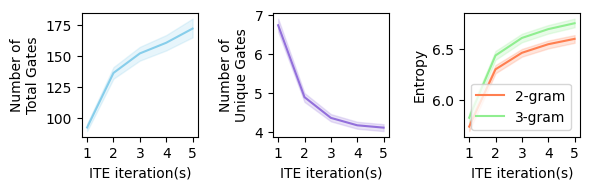

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_programs is already defined and contains the 'num_ops' and 'round' columns
fig_diversity, diversity_axes = plt.subplots(1, 3, figsize=(6, 2))

# Number of Operations per Round
sns.lineplot(x='round', y='num_ops', data=df_programs,
             ax=diversity_axes[0], color='skyblue')
diversity_axes[0].set_xlabel('ITE iteration(s)')
diversity_axes[0].set_ylabel('Number of\nTotal Gates')
diversity_axes[0].set_xticks(range(1, df_programs['round'].max() + 1))

# Gate Set Size per Round
sns.lineplot(x='round', y='num_ops_only_type', data=df_programs,
             ax=diversity_axes[1], color='mediumpurple')
diversity_axes[1].set_xlabel('ITE iteration(s)')
diversity_axes[1].set_ylabel('Number of\nUnique Gates')
diversity_axes[1].set_xticks(range(1, df_programs['round'].max() + 1))

# 2-gram and 3-gram Entropy per Round on same plot
sns.lineplot(x='round', y='entropy_2gram', data=df_programs,
             ax=diversity_axes[2], color='coral', label='2-gram')
sns.lineplot(x='round', y='entropy_3gram', data=df_programs,
             ax=diversity_axes[2], color='lightgreen', label='3-gram')
diversity_axes[2].set_xlabel('ITE iteration(s)')
diversity_axes[2].set_ylabel('Entropy')
diversity_axes[2].set_xticks(range(1, df_programs['round'].max() + 1))
diversity_axes[2].legend()

plt.tight_layout()
plt.savefig('images/rq_program_diversity_combined.pdf')
plt.show()

## Crashes and Inconsistencies across ITE Iterations

In [ ]:
# Initialize lists to store all error, comparison, and metadata data
all_errors_data = []
all_comparison_data = []
all_metadata_data = []

# Process each coverage experiment
for exp_name in EXPERIMENTS_COVERAGE:
    # error_folder = Path(EXPERIMENTS_QITE[exp_name]["path"]) / "error"
    # comparison_folder = Path(EXPERIMENTS_QITE[exp_name]["path"]) / "comparison"
    # metadata_folder = Path(EXPERIMENTS_QITE[exp_name]["path"]) / "metadata"

    # Read all JSON files in the error folder
    for error_subfolder in ["error", "converter_error"]:
        df_errors = read_all_jsons(
            Path(EXPERIMENTS_QITE[exp_name]["path"]) / error_subfolder)
        df_errors['experiment'] = exp_name
        # keep only if "_filename" has "_qite_" in it
        # df_errors = df_errors[df_errors['_filename'].str.contains(
        # "_qite_")]
        all_errors_data.extend(df_errors.to_dict('records'))

    # Read all JSON files in the comparison folder
    # all starting with "comparison"
    all_comparison_folders = [
        f for f in os.listdir(Path(EXPERIMENTS_QITE[exp_name]["path"]))
        if f.startswith("comparison")
    ]
    for comparison_subfolder in all_comparison_folders:
        df_comparisons = read_all_jsons(
            Path(EXPERIMENTS_QITE[exp_name]["path"]) / comparison_subfolder)
        df_comparisons['experiment'] = exp_name
        df_comparisons['round'] = int(comparison_subfolder.split("_")[-1])
        all_comparison_data.extend(df_comparisons.to_dict('records'))

    # Read all JSON files in the metadata folder
    for metadata_subfolder in ["metadata", "converter_metadata"]:
        df_metadata = read_all_jsons(
            Path(EXPERIMENTS_QITE[exp_name]["path"]) / metadata_subfolder)
        df_metadata['experiment'] = exp_name
        # keep only if "_filename" has "_qite_" in it
        df_metadata = df_metadata[df_metadata['_filename'].str.contains(
            "_qite_")]
        all_metadata_data.extend(df_metadata.to_dict('records'))

# Convert all collected data to DataFrames
df_all_errors = pd.DataFrame(all_errors_data)
df_all_comparisons = pd.DataFrame(all_comparison_data)
df_all_metadata = pd.DataFrame(all_metadata_data)

# Display summary information for errors
print("Error Summary:")
print(f"Total errors across all experiments: {len(df_all_errors)}")
print("\nErrors per experiment:")
print(df_all_errors['experiment'].value_counts())
# print("\nError columns:", df_all_errors.columns)

# Display summary information for comparisons
print("\nComparison Summary:")
print(f"Total comparisons across all experiments: {len(df_all_comparisons)}")
print("\nComparisons per experiment:")
print(df_all_comparisons['experiment'].value_counts())
# print("\nComparison columns:", df_all_comparisons.columns)

# Display summary information for metadata
print("\nMetadata Summary:")
print(f"Total metadata entries across all experiments: {len(df_all_metadata)}")
print("\nMetadata per experiment:")
print(df_all_metadata['experiment'].value_counts())
# print("\nMetadata columns:", df_all_metadata.columns)

Error Summary:
Total errors across all experiments: 3013

Errors per experiment:
experiment
2025_03_11__23_22_96bacf    618
2025_03_11__23_22_3d489d    604
2025_03_11__23_22_7c755e    601
2025_03_11__23_22_38ce99    600
2025_03_11__23_22_afbb03    590
Name: count, dtype: int64

Comparison Summary:
Total comparisons across all experiments: 40334

Comparisons per experiment:
experiment
2025_03_11__23_22_afbb03    8292
2025_03_11__23_22_7c755e    8119
2025_03_11__23_22_3d489d    8101
2025_03_11__23_22_38ce99    8092
2025_03_11__23_22_96bacf    7730
Name: count, dtype: int64

Metadata Summary:
Total metadata entries across all experiments: 10094

Metadata per experiment:
experiment
2025_03_11__23_22_afbb03    2091
2025_03_11__23_22_38ce99    2036
2025_03_11__23_22_7c755e    2030
2025_03_11__23_22_3d489d    2022
2025_03_11__23_22_96bacf    1915
Name: count, dtype: int64


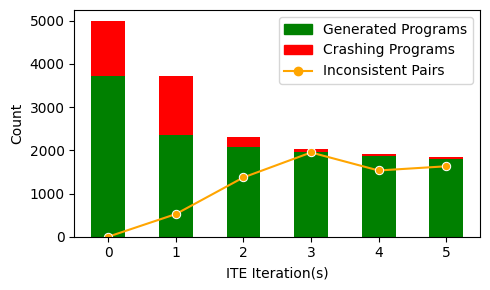

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Create a temporary dataframe to hold the counts for each category
df_tmp = pd.DataFrame()

# Count crashing programs per round
df_tmp['crashing_programs'] = df_all_errors.groupby('round').size()

# Count inconsistent pairs per round
df_tmp['inconsistent_pairs'] = df_all_comparisons[
    df_all_comparisons['equivalence'] == 'not_equivalent'].groupby('round').size()

# Count generated programs per round
df_tmp['generated_programs'] = df_all_metadata.groupby('round').size()

# Fill NaN values with 0
df_tmp = df_tmp.fillna(0)

# Add the initial programs to round 0
df_tmp.loc[0, 'generated_programs'] = N_INITIAL_PROGRAMS * 5 - df_tmp.loc[0,
                                                                          'crashing_programs']

# Reset index to make 'round' a column
df_tmp = df_tmp.reset_index()

# Plot the stacked barplot
fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot the bar plot for generated and crashing programs
df_tmp.plot(
    x='round',
    y=['generated_programs', 'crashing_programs'],
    kind='bar',
    stacked=True,
    color=['green', 'red'],
    ax=ax1
)

# Plot the line plot for inconsistent pairs on the same axis
sns.lineplot(
    data=df_tmp,
    x='round',
    y='inconsistent_pairs',
    color='orange',
    ax=ax1,
    marker='o'
)

# Set labels and title
ax1.set_xlabel('ITE Iteration(s)')
ax1.set_ylabel('Count')

# Rotate x-axis labels to be horizontal
plt.xticks(rotation=0)

# Create custom legend handles to match the colors
legend_handles = [
    Patch(color='green', label='Generated Programs'),
    Patch(color='red', label='Crashing Programs'),
    Line2D([0], [0], color='orange', label='Inconsistent Pairs', marker='o')
]

ax1.legend(handles=legend_handles, loc='upper right')

plt.tight_layout()
plt.show()

fig.savefig('images/rq_programs_warning_over_rounds.pdf')

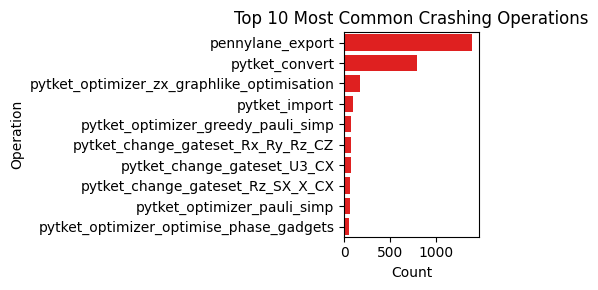


Crashing operation counts:
crashing_operation
pennylane_export                              1392
pytket_convert                                 789
pytket_optimizer_zx_graphlike_optimisation     171
pytket_import                                   97
pytket_optimizer_greedy_pauli_simp              76
pytket_change_gateset_Rx_Ry_Rz_CZ               73
pytket_change_gateset_U3_CX                     71
pytket_change_gateset_Rz_SX_X_CX                68
pytket_optimizer_pauli_simp                     64
pytket_optimizer_optimise_phase_gadgets         57
pytket_change_gateset_U1_U2_U3_CX               54
pytket_export                                   44
pennylane_import                                29
qiskit_import                                   26
pytket_optimizer_kak_decomposition               2
Name: count, dtype: int64


In [ ]:

# Create a count plot of the most frequent crashing operations
plt.figure(figsize=(5, 3))
sns.countplot(
    data=df_all_errors, y='crashing_operation',
    order=df_all_errors['crashing_operation'].value_counts().index[: 10],
    color='red')

plt.title('Top 10 Most Common Crashing Operations')
plt.xlabel('Count')
plt.ylabel('Operation')
plt.tight_layout()
plt.savefig('images/rq_crashing_operations.pdf')
plt.show()

# Print the counts
print("\nCrashing operation counts:")
print(df_all_errors['crashing_operation'].value_counts())

## Coverage Over ITE Iterations

In [ ]:
coverage_data_over_time = []
# coverage_xml_path = Path(
#     EXPERIMENTS_QITE[SELECTED_EXP_QITE]["path"]) / "coverage_xml"

for exp_name in EXPERIMENTS_COVERAGE:
    print("-" * 80)
    print(f"Experiment: {exp_name}. Loading Coverage.")
    exp_data = EXPERIMENTS_QITE[exp_name]
    coverage_xml_path = Path(exp_data["path"]) / "coverage_xml"

    # Get all numeric subdirectories and sort them
    time_dirs = sorted(
        [d for d in coverage_xml_path.iterdir()
         if d.is_dir() and d.name.isdigit()],
        key=lambda x: int(x.name))

    for time_dir in time_dirs:
        coverage_file = time_dir / "coverage_platforms.json"
        if coverage_file.exists():
            with open(coverage_file, "r") as f:
                coverage_data = json.load(f)
                # Add timestamp information
                metadata = json.load(
                    (time_dir / "_qite_stats.jsonl").open("r"))
                coverage_data["round"] = int(metadata["round"])
                coverage_data["timestamp"] = int(time_dir.name)
                coverage_data['experiment'] = exp_name
                coverage_data_over_time.append(coverage_data)

# Convert to DataFrame for easier analysis
df_coverage = pd.DataFrame(coverage_data_over_time)
# print("columns: ", list(df_coverage.columns))

# for all the columns except time, expand their content and make new records with the same time and each of the cell of the different remaining cols
# Convert nested dictionary structure to a more usable format
data_expanded = []
for _, row in df_coverage.iterrows():
    timestamp = row['timestamp']
    n_round = row["round"]
    exp_name = row["experiment"]
    for platform in PLATFORMS:
        platform_data = row[platform]
        data_expanded.append({
            'timestamp': timestamp,
            'experiment': exp_name,
            'round': n_round,
            'platform': platform,
            'coverage_percentage': platform_data['coverage_percentage'],
            'covered': platform_data['covered'],
            'total': platform_data['total'],
            'covered_lines': platform_data['covered_lines'],
            'total_lines': platform_data['total_lines']
        })


df_coverage_expanded = pd.DataFrame(data_expanded)
# keep only timestamp up to 5 included
df_coverage_expanded = df_coverage_expanded[df_coverage_expanded
                                            ["timestamp"] <= 5]

--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_3d489d. Loading Coverage.
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_7c755e. Loading Coverage.
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_38ce99. Loading Coverage.
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_96bacf. Loading Coverage.
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_afbb03. Loading Coverage.


In [ ]:
# compute cumulative coverage

df = df_coverage_expanded.copy()
# get a dictioanry with the highest "total" for each platofrm
map_max_total = df.groupby("platform")["total"].max().to_dict()
# replace the total with the max total for each platform
df["total"] = df["platform"].map(map_max_total)

# group by platform and round, merge the lines set and get the list of the rest
df = df.groupby(["experiment", "platform", "round"]).agg({
    'timestamp': 'first',
    'total': 'first',
    'covered_lines': 'sum',
}).reset_index()

# consider subset of platforms, sort them by round and timestamp
# compute the cumulative sum of covered lines (as set)
dfs = []
for platform in PLATFORMS:
    df_platform = df[df["platform"] == platform].sort_values(
        by=["round", "timestamp"])
    df_platform["cumulative_covered_lines"] = df_platform["covered_lines"].cumsum()
    # create set
    df_platform["cumulative_covered_lines"] = df_platform["cumulative_covered_lines"].apply(
        set)
    df_platform['n_covered'] = df_platform['cumulative_covered_lines'].apply(
        len)
    dfs.append(df_platform)

df = pd.concat(dfs)
df["covered_cumulative_percentage"] = df["n_covered"] / df["total"] * 100

df.drop(columns=["covered_lines", "cumulative_covered_lines"], inplace=True)

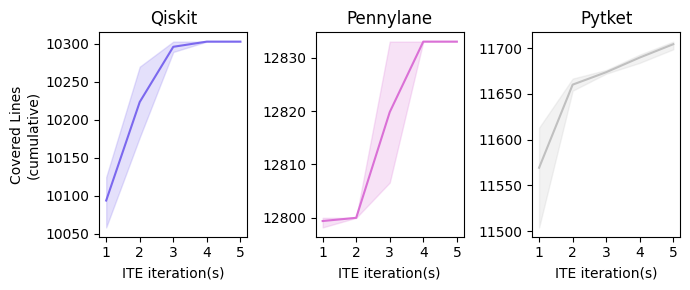

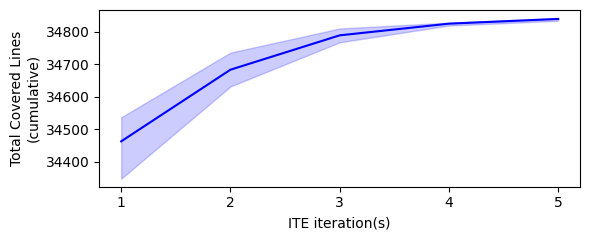

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(7, 3), squeeze=False)

# Create subplot for each platform
for idx, platform in enumerate(PLATFORMS):
    platform_data = df[df['platform'] == platform]

    # Plot covered lines over time
    sns.lineplot(data=platform_data, x='round', y='n_covered',
                 color=PLATFORM_COLORS[platform], ax=axs[0, idx])
    axs[0, idx].set_title(platform.capitalize())
    if idx == 0:  # Only add ylabel for leftmost plots
        axs[0, idx].set_ylabel('Covered Lines\n(cumulative)')
    else:
        axs[0, idx].set_ylabel('')
    axs[0, idx].set_xlabel('ITE iteration(s)')

    axs[0, idx].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig('images/rq_coverage_over_time.pdf')
plt.show()


# Aggregate all platforms by summing the total number of covered lines across rounds
df_aggregated = df.groupby(['round', 'experiment'])[
    'n_covered'].sum().reset_index()
# Create a single line plot for the total number of covered lines across rounds
plt.figure(figsize=(6, 2.5))
sns.lineplot(data=df_aggregated, x='round', y='n_covered', color='blue')
plt.xlabel('ITE iteration(s)')
plt.ylabel('Total Covered Lines\n(cumulative)')
plt.xticks(range(1, df['round'].max() + 1))
plt.tight_layout()
plt.savefig('images/rq_total_coverage_over_time.pdf')
plt.show()

# RQ3: Comparison with Prior Work

In [9]:
# todo add coverage data to a dictionary to use later easily for the venn
COVERAGE_DATA_ALL = {}

for exp_name, exp_info in EXPERIMENTS_ALL.items():
    print(
        f"Experiment: {exp_name} - ({exp_info['description']}) - {exp_info['provenance']}")
    if "coverage_xml" in os.listdir(
            exp_info["path"]) or "coverage" in os.listdir(
            exp_info["path"]):
        # new experiments with coverage each round
        latest_coverage_folder = Path(exp_info["path"]) / "coverage_xml"
        if not latest_coverage_folder.exists():
            latest_coverage_folder = Path(exp_info["path"]) / "coverage"
        # Get all subdirectories that are numeric and zerothed
        coverage_dirs = sorted([
            d.name for d in latest_coverage_folder.iterdir()
            if d.is_dir() and d.name.isdigit()])
        if coverage_dirs:
            exp_coverage_folder = latest_coverage_folder / coverage_dirs[0]
            print(f"Coverage data found in {exp_coverage_folder}")
        else:
            raise Exception("No coverage data found")
    else:
        # morphq or old qite experiments
        exp_coverage_folder = exp_info["path"]
    exp_coverage_data_path = Path(
        exp_coverage_folder) / "coverage_platforms.json"
    with open(exp_coverage_data_path, "r") as f:
        exp_coverage_data = json.load(f)
    COVERAGE_DATA_ALL[exp_name] = exp_coverage_data
    # for package, coverage in exp_coverage_data.items():
    #     print(
    #         f"{package:_<15}: {coverage['coverage_percentage']:.2f}% ({coverage['covered']}/{coverage['total']})")
    print("-" * 80)

Experiment: v26 - (MorphQ Data - 1h - RQ: Comparison of QITE and MorphQ) - morphq
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_3d489d - (1000 programs - RQs: ITE iterations (RQ2) and efficiency (RQ4)) - qite
Coverage data found in ../program_bank/v048/2025_03_11__23_22_3d489d/coverage_xml/0001
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_7c755e - (1000 programs - RQs: ITE iterations (RQ2) and efficiency (RQ4)) - qite
Coverage data found in ../program_bank/v048/2025_03_11__23_22_7c755e/coverage_xml/0001
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_38ce99 - (1000 programs - RQs: ITE iterations (RQ2) and efficiency (RQ4)) - qite
Coverage data found in ../program_bank/v048/2025_03_11__23_22_38ce99/coverage_xml/0001
--------------------------------------------------------------------------------


In [17]:
from matplotlib_venn import venn2

# Styling constants
FIGURE_SIZE = (6, 3)
# light purple, light gray, white
STYLE_COLORS = ['mediumpurple', 'darkgray', 'white']
OUTPUT_IMAGE_PATH = "images/rq_coverage_venn_vs_morphq.pdf"


@dataclass
class VennDiagramData:
    """Data structure for Venn diagram components."""
    exclusive_set1: Set[str]
    exclusive_set2: Set[str]
    intersection: Set[str]


def calculate_venn_sets(set1: Set[str], set2: Set[str]) -> VennDiagramData:
    """Calculate exclusive and intersection sets for Venn diagram."""
    return VennDiagramData(
        exclusive_set1=set1 - set2,
        exclusive_set2=set2 - set1,
        intersection=set1 & set2,
    )


def style_venn_diagram(venn: Any, data: VennDiagramData) -> None:
    """Apply styling to Venn diagram components."""
    # Set size labels
    for id, size in [
        ('10', len(data.exclusive_set1)),
        ('01', len(data.exclusive_set2)),
        ('11', len(data.intersection))
    ]:
        venn.get_label_by_id(id).set_text(size)

    # Style sections
    venn.get_patch_by_id('10').set_color(STYLE_COLORS[0])
    patch01 = venn.get_patch_by_id('01')
    patch01.set_edgecolor(STYLE_COLORS[0])
    patch01.set_linestyle('dashed')
    patch01.set_facecolor('white')
    venn.get_patch_by_id('11').set_color(STYLE_COLORS[1])


def create_coverage_venn_diagram(
    qite_lines: Set[str],
    morphq_lines: Set[str],
    qite_label: str = 'QITE',
    morphq_label: str = 'MorphQ',
    show_plot: bool = True,
) -> Tuple[plt.Figure, plt.Axes, VennDiagramData]:
    """Create and style Venn diagram comparing covered lines."""
    venn_data = calculate_venn_sets(qite_lines, morphq_lines)
    if not show_plot:
        return None, None, venn_data

    fig, ax = plt.subplots(figsize=FIGURE_SIZE)

    venn = venn2(
        subsets=[qite_lines, morphq_lines],
        set_labels=(qite_label, morphq_label),
        ax=ax,
    )
    style_venn_diagram(venn, venn_data)

    plt.show()
    fig.savefig(OUTPUT_IMAGE_PATH)
    return fig, ax, venn_data


def print_latex_commands(
    cov_qiskit_ours: dict,
    cov_qiskit_morphq: dict,
    venn_data: VennDiagramData,
) -> None:
    """
    Print LaTeX commands for coverage statistics.

    Args:
        cov_qiskit_ours: Coverage data from QITE approach
        cov_qiskit_morphq: Coverage data from MorphQ approach
        venn_data: VennDiagramData containing set intersection info
    """
    coverage_commands = [
        ("QITEQiskitCoverage",
            f"{cov_qiskit_ours['coverage_percentage']:.2f}\\%"),
        ("MorphQQiskitCoverage",
            f"{cov_qiskit_morphq['coverage_percentage']:.2f}\\%"),
        ("QITEQiskitTotalLines",
            f"{cov_qiskit_ours['total']:,.0f}"),
        ("MorphQQiskitTotalLines",
            f"{cov_qiskit_morphq['total']:,.0f}"),
        ("QITEQiskitCoveredLines",
            f"{cov_qiskit_ours['covered']:,.0f}"),
        ("MorphQQiskitCoveredLines",
            f"{cov_qiskit_morphq['covered']:,.0f}"),
        ("CoveredSharedLines", f"{len(venn_data.intersection):,.0f}"),
        ("CoveredOnlyQITE", f"{len(venn_data.exclusive_set1):,.0f}"),
        ("CoveredOnlyMorphQ", f"{len(venn_data.exclusive_set2):,.0f}"),
    ]

    for cmd_name, value in coverage_commands:
        print(f"\\newcommand{{\\{cmd_name}}}{{{value}}}")


cov_morphq = COVERAGE_DATA_ALL[SELECTED_EXP_MORPHQ]

for exp_name in [SELECTED_EXP_QITE]:
    print("Coverage comparison")
    print("-" * 80)
    print(f"QITE experiment: {exp_name}")
    print(f"Description: {EXPERIMENTS_ALL[exp_name]['description']}")
    print("-" * 80)
    print(f"MorphQ experiment: {SELECTED_EXP_MORPHQ}")
    print(f"Description: {EXPERIMENTS_ALL[exp_name]['description']}")
    print("-" * 80)
    cov_qite = COVERAGE_DATA_ALL[exp_name]
    # Example usage remains the same but with named arguments
    fig, ax, venn_data = create_coverage_venn_diagram(
        qite_lines=set(cov_qite["qiskit"]["covered_lines"]),
        morphq_lines=set(cov_morphq["qiskit"]["covered_lines"]),
        show_plot=False
    )
    print_latex_commands(
        cov_qiskit_ours=cov_qite["qiskit"],
        cov_qiskit_morphq=cov_morphq["qiskit"],
        venn_data=venn_data,
    )

Coverage comparison
--------------------------------------------------------------------------------
QITE experiment: 2025_03_12__01_31_bbcb5d
Description: 1h - RQ: Comparison of QITE and MorphQ
--------------------------------------------------------------------------------
MorphQ experiment: v26
Description: 1h - RQ: Comparison of QITE and MorphQ
--------------------------------------------------------------------------------
\newcommand{\QITEQiskitCoverage}{14.03\%}
\newcommand{\MorphQQiskitCoverage}{16.75\%}
\newcommand{\QITEQiskitTotalLines}{72,751}
\newcommand{\MorphQQiskitTotalLines}{72,751}
\newcommand{\QITEQiskitCoveredLines}{10,204}
\newcommand{\MorphQQiskitCoveredLines}{12,188}
\newcommand{\CoveredSharedLines}{9,386}
\newcommand{\CoveredOnlyQITE}{818}
\newcommand{\CoveredOnlyMorphQ}{2,802}


QITE - All Platforms coverage


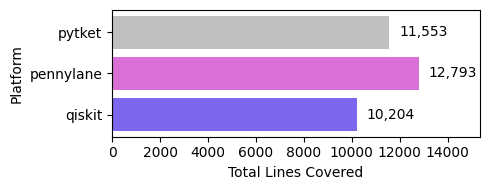

\newcommand{\QITEQiskitTotalLines}{72,751}
\newcommand{\QITEQiskitCoveredLines}{10,204}
\newcommand{\QITEPennylaneTotalLines}{47,509}
\newcommand{\QITEPennylaneCoveredLines}{12,793}
\newcommand{\QITEPytketTotalLines}{38,416}
\newcommand{\QITEPytketCoveredLines}{11,553}
\newcommand{\QITEAllPlatformsCoveredLines}{34,550}


In [18]:
PLATFORM_COLORS = {'qiskit': 'mediumslateblue',
                   'pytket': 'silver', 'pennylane': 'orchid'}
OUTPUT_DIR = "images"
OUTPUT_PATH_BAR_PLOT = os.path.join(OUTPUT_DIR, "rq_coverage_barplot.pdf")


def create_platform_bar_plot(package_coverage, platforms, output_path):
    """Generates and saves a horizontal bar plot of platform coverage."""
    platform_colors = [PLATFORM_COLORS[platform] for platform in platforms]
    total_lines_covered = [package_coverage[platform]['covered']
                           for platform in platforms]

    fig, ax = plt.subplots(figsize=(5, 2))
    bars = ax.barh(platforms, total_lines_covered, color=platform_colors)
    ax.set_xlabel('Total Lines Covered')
    ax.set_ylabel('Platform')

    max_val = max(total_lines_covered)
    add_bar_value_labels(ax, bars, total_lines_covered, max_val)

    ax.set_xlim(0, max_val * 1.2)
    fig.tight_layout()
    plt.show()
    fig.savefig(output_path)


def add_bar_value_labels(ax, bars, values, max_val):
    """Adds labels to the end of each bar in a horizontal bar plot."""
    for bar, value in zip(bars, values):
        ax.text(value + (max_val / 30), bar.get_y() + bar.get_height() / 2,
                f'{value:,.0f}', va='center', ha='left')


def print_latex_commands(package_coverage, platforms):
    """Prints LaTeX commands for total and covered lines for each platform."""
    n_covered_lines_all_platforms = 0
    for platform in platforms:
        total_lines = package_coverage[platform]['total']
        covered_lines = package_coverage[platform]['covered']
        n_covered_lines_all_platforms += covered_lines
        print(
            f"\\newcommand{{\\QITE{platform.capitalize()}TotalLines}}{{{total_lines:,.0f}}}")
        print(
            f"\\newcommand{{\\QITE{platform.capitalize()}CoveredLines}}{{{covered_lines:,.0f}}}")
    print(
        f"\\newcommand{{\\QITEAllPlatformsCoveredLines}}{{{n_covered_lines_all_platforms:,.0f}}}")


# Main execution
print("QITE - All Platforms coverage")
create_platform_bar_plot(
    package_coverage=COVERAGE_DATA_ALL[SELECTED_EXP_QITE],
    platforms=PLATFORMS,
    output_path=OUTPUT_PATH_BAR_PLOT,
)
print_latex_commands(
    package_coverage=COVERAGE_DATA_ALL[SELECTED_EXP_QITE],
    platforms=PLATFORMS)

## Unique Lines Covered by QITE and MorphQ

QITE experiment: 2025_03_12__01_31_bbcb5d
MorphQ experiment: v26
Total lines covered only by QITE: 818
circuit/library/generalized_gates/: 16 lines
circuit/library/data_preparation/: 24 lines
circuit/library/standard_gates/: 229 lines
transpiler/passes/synthesis/: 1 lines
crates/accelerate/src/: 126 lines
synthesis/one_qubit/: 9 lines
synthesis/two_qubit/: 1 lines
crates/circuit/src/: 83 lines
crates/qasm2/src/: 151 lines
circuit/tools/: 17 lines
circuit/: 130 lines
qasm2/: 31 lines
Total lines covered only by QITE: 818
\newcommand{\LinesOnlyQITEQasmTwo}{182}
\newcommand{\LinesOnlyQITEAdvOpt}{126}
\newcommand{\LinesOnlyQITEGatesRelated}{245}
\newcommand{\LinesOnlyQITESimRelated}{0}
\newcommand{\LinesOnlyQITERoutingRelated}{0}


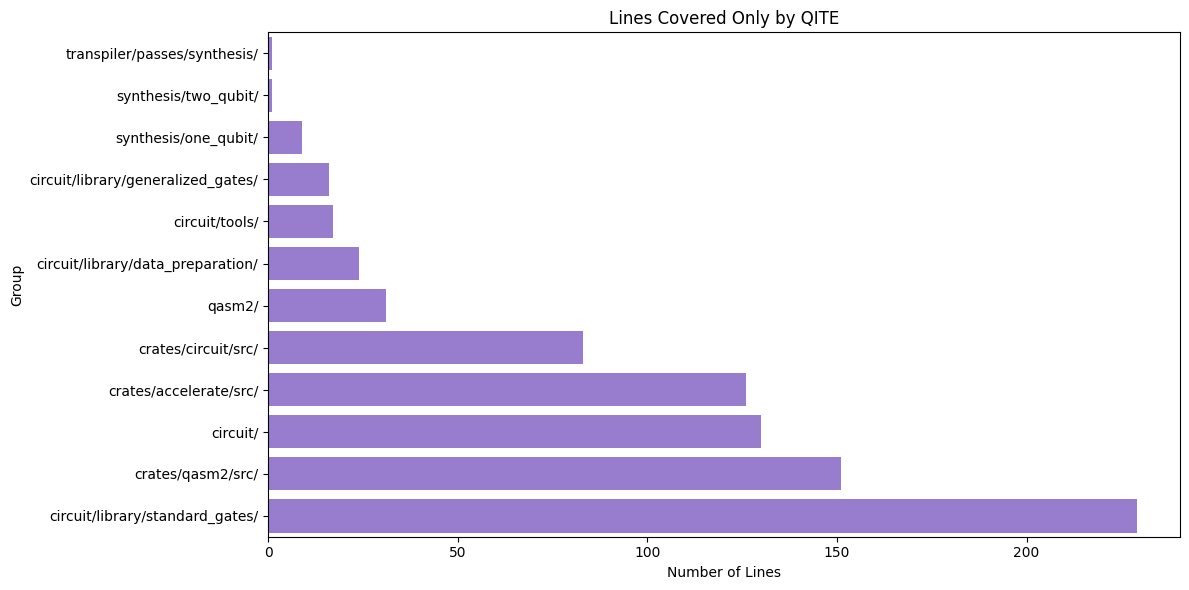

Total lines covered only by MorphQ: 2802
circuit/library/standard_gates/: 41 lines
transpiler/passes/optimization/: 43 lines
transpiler/preset_passmanagers/: 123 lines
transpiler/passes/scheduling/: 1 lines
transpiler/passes/synthesis/: 10 lines
transpiler/passes/routing/: 64 lines
transpiler/passes/layout/: 342 lines
transpiler/passes/basis/: 21 lines
transpiler/passes/utils/: 66 lines
crates/accelerate/src/: 1185 lines
crates/circuit/src/: 198 lines
crates/qasm2/src/: 40 lines
crates/qasm3/src/: 9 lines
passmanager/: 10 lines
dagcircuit/: 64 lines
converters/: 3 lines
primitives/: 188 lines
transpiler/: 248 lines
providers/: 34 lines
compiler/: 4 lines
circuit/: 45 lines
result/: 49 lines
qasm2/: 6 lines
pulse/: 4 lines
utils/: 2 lines
qobj/: 2 lines
Total lines covered only by MorphQ: 2802
\newcommand{\LinesOnlyMorphQQasmTwo}{46}
\newcommand{\LinesOnlyMorphQAdvOpt}{1228}
\newcommand{\LinesOnlyMorphQGatesRelated}{41}
\newcommand{\LinesOnlyMorphQSimRelated}{273}
\newcommand{\LinesOnly

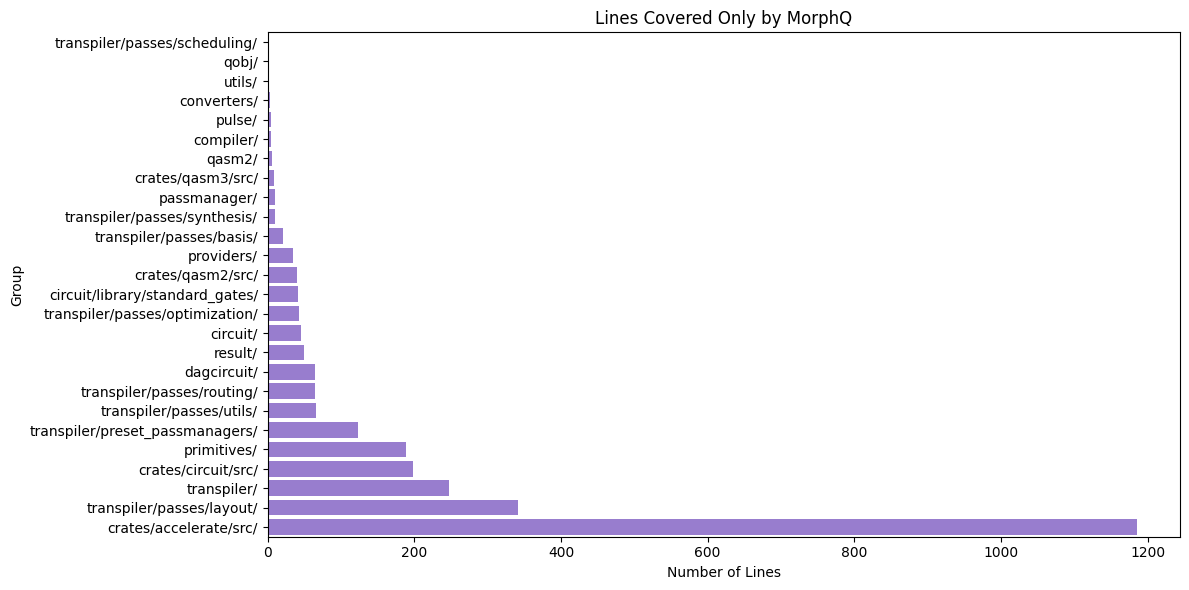

In [ ]:
def compare_line_coverage(include_lines: Set[str], exclude_lines: Set[str],
                          include_label: str, exclude_label: str,
                          file_patterns: List[str] = ["rs", "py"],
                          folder_prefixes: List[str] = None) -> None:
    """
    Analyze and print code lines covered by one approach but not another, grouped by prefixes.

    Args:
        include_lines: Set of lines to analyze for exclusive coverage
        exclude_lines: Set of lines to exclude
        include_label: Label for the include set (e.g. "QITE")
        exclude_label: Label for the exclude set (e.g. "MorphQ")
        file_patterns: List of file extensions to filter (default: ["rs", "py"])
        folder_prefixes: List of folder prefixes to group by (default: None)
    """
    exclusive_lines = {
        line for line in (include_lines - exclude_lines)
        if any(f".{pattern}:" in line for pattern in file_patterns)
    }

    # Sort prefixes by length (longest first) if provided
    sorted_prefixes = sorted(folder_prefixes, key=len,
                             reverse=True) if folder_prefixes else []

    # Group by prefix and files
    prefix_groups = {prefix: [] for prefix in sorted_prefixes}
    prefix_groups['other'] = []  # For files matching no prefix

    for line in sorted(exclusive_lines):
        file_path, line_number = line.split(':')
        line_num = int(line_number)

        # Try to match with prefixes
        matched = False
        for prefix in sorted_prefixes:
            if file_path.startswith(prefix):
                prefix_groups[prefix].append(line_num)
                matched = True
                break

        # If no prefix matched, group by file in 'other'
        if not matched:
            prefix_groups['other'].append((file_path, line_num))

    # Print summary
    print(
        f"Total lines covered only by {include_label}: {len(exclusive_lines)}")

    # Create data for plotting
    plot_data = []

    # Process prefix groups
    for prefix, lines in prefix_groups.items():
        if prefix == 'other':
            # Group remaining files
            file_groups = {}
            for file_path, line_num in lines:
                if file_path not in file_groups:
                    file_groups[file_path] = []
                file_groups[file_path].append(line_num)

            for file_path, file_lines in file_groups.items():
                plot_data.append({
                    'group': file_path,
                    'lines': len(file_lines)
                })
        else:
            if lines:  # Only add non-empty prefix groups
                plot_data.append({
                    'group': prefix,
                    'lines': len(lines)
                })
    for data in plot_data:
        print(f"{data['group']}: {data['lines']} lines")

    # Print LaTeX command
    print(
        f"Total lines covered only by {include_label}: {len(exclusive_lines)}")

    if prefix_groups:
        print_latex_precise_lines(include_lines, include_label, plot_data)

    # Create bar plot
    plt.figure(figsize=(12, 6))
    df_plot = pd.DataFrame(plot_data)
    df_plot = df_plot.sort_values('lines', ascending=True)

    sns.barplot(data=df_plot, y='group', x='lines', color='mediumpurple')
    plt.title(f'Lines Covered Only by {include_label}')
    plt.xlabel('Number of Lines')
    plt.ylabel('Group')

    plt.tight_layout()
    plt.savefig(
        f'images/coverage_comparison_{include_label}_{exclude_label}.pdf')
    plt.show()


def print_latex_precise_lines(
        include_lines: Set[str],
        include_label: str, plot_data: List[Dict[str, Any]]) -> None:
    """
    Print LaTeX commands for precise line coverage statistics.
    """
    # qasm2 lines: sum al lines with group containing qasm2
    qasm2_lines = sum([
        data['lines'] for data in plot_data if 'qasm2' in data['group']])
    print(
        f"\\newcommand{{\\LinesOnly{include_label}QasmTwo}}{{{qasm2_lines}}}")

    # advanced optimization: "crates/accelerate/src/" and 'transpiler/passes/optimization/"
    # sum all lines with group containing crates/accelerate/src/ and transpiler/passes/optimization/
    # crates/accelerate/src/
    adv_opt_lines = sum([
        data['lines'] for data in plot_data if 'crates/accelerate/src/' in data['group']
        or 'transpiler/passes/optimization/' in data['group']])
    print(
        f"\\newcommand{{\\LinesOnly{include_label}AdvOpt}}{{{adv_opt_lines}}}")

    # gates related: "circuit/library/standard_gates/" and "circuit/library/generalized_gates/"
    gates_lines = sum([data['lines'] for data in plot_data
                       if 'circuit/library/standard_gates/' in data
                       ['group'] or 'circuit/library/generalized_gates/' in data
                       ['group']])
    print(
        f"\\newcommand{{\\LinesOnly{include_label}GatesRelated}}{{{gates_lines}}}")

    # simulation related: "providers/" and "result/" and "qobj/" and "primitives"
    sim_lines = sum([
        data['lines'] for data in plot_data if 'providers/' in data['group']
        or 'result/' in data['group']
        or 'qobj/' in data['group']
        or 'primitives/' in data['group']
    ])
    print(
        f"\\newcommand{{\\LinesOnly{include_label}SimRelated}}{{{sim_lines}}}")

    # routing related: "transpiler/passes/routing/" and "transpiler/passes/layout/"
    routing_lines = sum([
        data['lines'] for data in plot_data if 'transpiler/passes/routing/' in data['group']
        or 'transpiler/passes/layout/' in data['group']
    ])
    print(
        f"\\newcommand{{\\LinesOnly{include_label}RoutingRelated}}{{{routing_lines}}}")


# Get coverage data for the selected experiments
print("QITE experiment:", SELECTED_EXP_QITE)
qite_coverage = COVERAGE_DATA_ALL[SELECTED_EXP_QITE]["qiskit"]
print("MorphQ experiment:", SELECTED_EXP_MORPHQ)
morphq_coverage = COVERAGE_DATA_ALL[SELECTED_EXP_MORPHQ]["qiskit"]

# Analyze Rust lines
# analyze_rust_lines(
#     qite_lines=set(qite_coverage["covered_lines"]),
#     morphq_lines=set(morphq_coverage["covered_lines"])
# )


relevant_folder_prefixes = [
    "circuit/library/standard_gates/",
    "circuit/library/generalized_gates/",
    "circuit/library/data_preparation/",
    "circuit/tools/",
    "crates/accelerate/src/",
    "crates/circuit/src/",
    "crates/qasm2/src/",
    "dagcircuit/",
    "qasm2/",
    "synthesis/one_qubit/",
    "transpiler/passes/basis/",
    "passmanager/",
    "circuit/",
    "compiler/",
    "converters/",
    "crates/qasm3/src/",
    "passmanager/",
    "primitives/",
    "providers/",
    "pulse/",
    "qobj/",
    "quantum_info/operators/",
    "result/",
    "synthesis/two_qubit/",
    "transpiler/passes/layout/",
    "transpiler/passes/optimization/",
    "transpiler/passes/routing/",
    "transpiler/passes/scheduling/",
    "transpiler/passes/synthesis/",
    "transpiler/passes/utils/",
    "transpiler/preset_passmanagers/",
    "transpiler/target/",
    "transpiler/",
    "utils/",
]


compare_line_coverage(
    include_lines=set(qite_coverage["covered_lines"]),
    exclude_lines=set(morphq_coverage["covered_lines"]),
    include_label="QITE",
    exclude_label="MorphQ",
    file_patterns=["rs", "py"],
    folder_prefixes=relevant_folder_prefixes
)

# the opposite
compare_line_coverage(
    include_lines=set(morphq_coverage["covered_lines"]),
    exclude_lines=set(qite_coverage["covered_lines"]),
    include_label="MorphQ",
    exclude_label="QITE",
    file_patterns=["rs", "py"],
    folder_prefixes=relevant_folder_prefixes
)

## Compare Warnings QITE and MorphQ

QITE experiment name: 2025_03_12__01_31_bbcb5d
MorphQ experiment name: v26


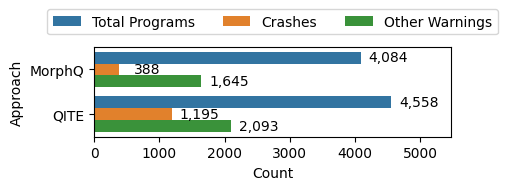

\newcommand{\TotalMorphQPrograms}{4,084}
\newcommand{\TotalOursPrograms}{4,558}
\newcommand{\RatioNewProgramsBestThenMorphQ}{1.12}
\newcommand{\TotalMorphQCrashes}{388}
\newcommand{\TotalOursCrashes}{1,195}
\newcommand{\RatioNewCrashesBestThenMorphQ}{3.08}
\newcommand{\TotalMorphQDivergences}{1,645}
\newcommand{\TotalOursDivergences}{2,093}
\newcommand{\RatioNewDivergencesBestThenMorphQ}{1.27}


In [15]:
import sqlite3 as sl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Any

# Global variables for MorphQ
PATH_PROGRAMS_MORPHQ = Path(
    EXPERIMENTS_MORPHQ[SELECTED_EXP_MORPHQ]["path"]) / "programs/source"
PATH_WARNINGS_MORPHQ = Path(
    EXPERIMENTS_MORPHQ[SELECTED_EXP_MORPHQ]["path"]) / "qfl.db"

# Global variables for QITE
ERROR_FOLDER_QITE = Path(EXPERIMENTS_QITE[SELECTED_EXP_QITE]["path"]) / "error"
CONVERTER_ERROR_FOLDER_QITE = Path(
    EXPERIMENTS_QITE[SELECTED_EXP_QITE]
    ["path"]) / "converter_error"
PROGRAM_FOLDER_QITE = Path(EXPERIMENTS_QITE[SELECTED_EXP_QITE]["path"])
COMPARISON_FOLDER_QITE = Path(
    EXPERIMENTS_QITE[SELECTED_EXP_QITE]["path"]) / get_comparison_folder_name(
    EXPERIMENTS_QITE[SELECTED_EXP_QITE]["path"])


def get_morphq_stats() -> Dict[str, int]:
    """Get program, crash and divergence counts for MorphQ"""
    conn = sl.connect(PATH_WARNINGS_MORPHQ)
    crashes_df = pd.read_sql("SELECT * from CRASHDATA", conn)
    executions_df = pd.read_sql("SELECT * from QFLDATA", conn)

    return {
        'programs': len([f for f in os.listdir(PATH_PROGRAMS_MORPHQ) if f.endswith('.py')]) * 2,
        'crashes': len(crashes_df),
        'divergences': len(executions_df)
    }


def get_qite_stats() -> Dict[str, int]:
    """Get program, crash and divergence counts for QITE"""
    return {
        'programs': len([f for f in os.listdir(PROGRAM_FOLDER_QITE) if f.endswith('.qasm')]),
        'crashes': len([f for f in os.listdir(ERROR_FOLDER_QITE) if f.endswith('.json')]) + len(
            [f for f in os.listdir(CONVERTER_ERROR_FOLDER_QITE) if f.endswith('.json')]),
        'divergences': len([f for f in os.listdir(COMPARISON_FOLDER_QITE) if f.endswith('.json')])
    }


def create_comparison_plot(
        morphq_stats: Dict[str, int],
        qite_stats: Dict[str, int]) -> None:
    """Create and save comparison barplot between MorphQ and QITE"""
    df_combined = pd.DataFrame({
        'Category': ['Total Programs', 'Crashes', 'Other Warnings'] * 2,
        'Approach': ['MorphQ'] * 3 + ['QITE'] * 3,
        'Count': [
            morphq_stats['programs'], morphq_stats['crashes'], morphq_stats['divergences'],
            qite_stats['programs'], qite_stats['crashes'], qite_stats['divergences']
        ]
    })

    fig, ax = plt.subplots(figsize=(5, 2.5))
    bar_plot = sns.barplot(y='Approach', x='Count',
                           hue='Category', data=df_combined, ax=ax)

    for p in bar_plot.patches:
        if p.get_width() != 0:
            bar_plot.annotate(
                format(p.get_width(), ',.0f'),
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='center', va='center', xytext=(20, 0), textcoords='offset points'
            )

    ax.set_ylabel('Approach')
    ax.set_xlim(0, max(df_combined['Count']) * 1.2)
    ax.set_xlabel('Count')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=3)

    plt.tight_layout(pad=1)
    plt.show()
    fig.savefig("images/rq_warnings.pdf", bbox_inches='tight')


def print_latex_stats_commands(
        morphq_stats: Dict[str, int],
        qite_stats: Dict[str, int]) -> None:
    """Print LaTeX commands for statistics comparison."""
    # Programs
    print("\\newcommand{\\TotalMorphQPrograms}{" +
          f"{morphq_stats['programs']:,.0f}" + "}")
    print("\\newcommand{\\TotalOursPrograms}{" +
          f"{qite_stats['programs']:,.0f}" + "}")
    ratio_programs = qite_stats['programs'] / morphq_stats['programs']
    print(
        "\\newcommand{\\RatioNewProgramsBestThenMorphQ}{" +
        f"{ratio_programs:.2f}" + "}")

    # Crashes
    print("\\newcommand{\\TotalMorphQCrashes}{" +
          f"{morphq_stats['crashes']:,.0f}" + "}")
    print(
        "\\newcommand{\\TotalOursCrashes}{" + f"{qite_stats['crashes']:,.0f}" + "}")
    ratio_crashes = qite_stats['crashes'] / morphq_stats['crashes']
    print(
        "\\newcommand{\\RatioNewCrashesBestThenMorphQ}{" +
        f"{ratio_crashes:.2f}" + "}")

    # Divergences
    print("\\newcommand{\\TotalMorphQDivergences}{" +
          f"{morphq_stats['divergences']:,.0f}" + "}")
    print("\\newcommand{\\TotalOursDivergences}{" +
          f"{qite_stats['divergences']:,.0f}" + "}")
    ratio_divergences = qite_stats['divergences'] / \
        morphq_stats['divergences'] if morphq_stats['divergences'] > 0 else 0
    print(
        "\\newcommand{\\RatioNewDivergencesBestThenMorphQ}{" +
        f"{ratio_divergences:.2f}" + "}")


# Main execution
print("QITE experiment name:", SELECTED_EXP_QITE)
print("MorphQ experiment name:", SELECTED_EXP_MORPHQ)
morphq_stats = get_morphq_stats()
qite_stats = get_qite_stats()
create_comparison_plot(morphq_stats, qite_stats)
print_latex_stats_commands(morphq_stats, qite_stats)

In [16]:
from typing import Dict, Any
import re
from multiprocessing import Pool
from pathlib import Path
import pandas as pd
import json
import os
import sqlite3 as sl

# QITE data processing


def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["_filename"] = os.path.basename(file_path)
        return data


def read_all_jsons(dir_path: str) -> pd.DataFrame:
    json_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path)
                  if re.match(r'.*\.json$', f)]
    with Pool() as pool:
        records = pool.map(read_json_file, json_files)
    return pd.DataFrame(records)


# Read QITE crashes from selected experiment
qite_error_folder = Path(EXPERIMENTS_ALL[SELECTED_EXP_QITE]["path"]) / "error"
df_qite_crashes = read_all_jsons(qite_error_folder)

# MorphQ data processing
morphq_db_path = Path(EXPERIMENTS_ALL[SELECTED_EXP_MORPHQ]["path"]) / "qfl.db"
conn = sl.connect(morphq_db_path)
df_morphq_crashes = pd.read_sql("SELECT * from CRASHDATA", conn)

# Anonymization functions


def anonymize_num_bits(input_text: str) -> str:
    if pd.isna(input_text):
        return input_text
    pattern = r"which acts on (\d+) classical bits"
    cleaned_text = re.sub(
        pattern, "which acts on <nr_bits> classical bits", input_text)
    return cleaned_text


def anonymize_gate_list(input_text: str) -> str:
    if pd.isna(input_text):
        return input_text
    pattern = r'circuit: \[.*?\] to'
    pattern_basis = r'target basis: \[.*?\]. This'
    cleaned_text = re.sub(pattern, 'circuit: __GATE_LIST__ to', input_text)
    cleaned_text = re.sub(
        pattern_basis, 'target basis: __GATE_LIST__ This', cleaned_text)
    return cleaned_text


def anonymize_filepath(input_text: str) -> str:
    if pd.isna(input_text):
        return input_text
    pattern = r'".*?\.qasm:\d+,\d+: '
    pattern_input = r'"<input>:\d+,\d+: '
    cleaned_text = re.sub(pattern, '__FILE_LOCATION__ ', input_text)
    cleaned_text = re.sub(pattern_input, '__FILE_LOCATION__ ', cleaned_text)
    return cleaned_text


# Create standardized dataframes
df_qite = pd.DataFrame({
    'id': df_qite_crashes['_filename'],
    'crash_msg': df_qite_crashes['error'],
    'anonymized_msg': df_qite_crashes['error'].apply(anonymize_filepath)
})

df_morphq = pd.DataFrame(
    {'id': df_morphq_crashes["followup.program_id"],
     'crash_msg': df_morphq_crashes['exceptions.followup'],
     'anonymized_msg': df_morphq_crashes['exceptions.followup'].apply(
         anonymize_gate_list).apply(anonymize_num_bits)})

# Print analysis results
print("QITE experiment:", SELECTED_EXP_QITE)
print("Unique crashes in QITE experiment:")
print(df_qite['anonymized_msg'].value_counts())
print(
    f"\nTotal unique crashes in QITE: {len(df_qite['anonymized_msg'].unique())}")
print("\nMorphQ experiment:", SELECTED_EXP_MORPHQ)
print("Unique crashes in MorphQ experiment:")
print(df_morphq['anonymized_msg'].value_counts())
print(
    f"\nTotal unique crashes in MorphQ: {len(df_morphq['anonymized_msg'].unique())}")


print("---")
print("\\newcommand{\\TotalUniqueQiteCrashes}{" +
      f"{len(df_qite['anonymized_msg'].unique())}" + "}")
print("\\newcommand{\\TotalUniqueMorphQCrashes}{" +
      f"{len(df_morphq['anonymized_msg'].unique())}" + "}")

QITE experiment: 2025_03_12__01_31_bbcb5d
Unique crashes in QITE experiment:
anonymized_msg
Operation QubitUnitary not supported by the QASM serializer                                                                                                                              379
Can only build replacement circuits for basic gates: CustomGate                                                                                                                          204
Gate has an invalid number of parameters                                                                                                                                                  37
Predicate requirements are not satisfied: NoClassicalBitsPredicate                                                                                                                        32
__FILE_LOCATION__ 'c4x' takes 5 quantum arguments, but got 4"                                                                                           

# RQ4: Efficiency

In [ ]:
from multiprocessing import Pool
import re
import json
import glob
pd.options.mode.chained_assignment = None


def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["_filename"] = os.path.basename(file_path)
        data["_folder"] = os.path.basename(os.path.dirname(file_path))
        return data


def read_all_json_files(base_path: str) -> pd.DataFrame:
    subfolders = ["metadata", "error", "generation_time",
                  "converter_metadata", "converter_error"]
    comparison_folder = get_comparison_folder_name(base_path)
    subfolders.append(comparison_folder)
    all_records = []

    with Pool() as pool:
        for subfolder in subfolders:
            folder_path = os.path.join(base_path, subfolder)
            if os.path.exists(folder_path):
                results = pool.map(
                    read_json_file, glob.glob(
                        os.path.join(folder_path, "*.json")))
                # print(results[0])
                all_records.extend(results)
    return pd.DataFrame(all_records)


# Create a DataFrame to store results from all experiments
all_combined_df = pd.DataFrame()

# Process each experiment in EXPERIMENTS_COVERAGE
for exp_name in EXPERIMENTS_COVERAGE:
    print("-" * 80)
    print(f"Experiment: {exp_name}. Loading Time Data.")
    # Get the base path for this experiment
    base_path = EXPERIMENTS_ALL[exp_name]["path"]

    # Read data for this experiment
    exp_df = read_all_json_files(base_path)

    # Add experiment name
    exp_df['experiment_name'] = exp_name

    # Append to main DataFrame
    all_combined_df = pd.concat([all_combined_df, exp_df], ignore_index=True)

# Process columns with list values
all_combined_df['transformer_functions'] = all_combined_df['transformer_functions'].parallel_apply(
    lambda x: x[0] if isinstance(x, list) and x else None)
all_combined_df['transformation_time'] = all_combined_df['transformation_time'].parallel_apply(
    lambda x: x[0] if isinstance(x, list) and x else None)
all_combined_df['platforms_compare'] = all_combined_df['qasms'].parallel_apply(
    lambda x: "-".join(sorted([x[0]["provenance"],
                               x[1]["provenance"]]))
    if isinstance(x, list) else None)

# all_combined_df.head()

# Select columns that contain 'time' in their name
time_columns = [col for col in all_combined_df.columns
                if 'time' in col and col != 'timestamp']
provenance_columns = ["experiment_name", "_filename", "_folder"]


# Create a new DataFrame with only the selected columns
df_time_combined = all_combined_df[time_columns + provenance_columns]
# convert all time columns to float
df_time_combined[time_columns] = df_time_combined[time_columns].astype(
    float).fillna(0)
# cap each transformation time to 10 seconds since it will not be blocking
# because the thread returns after 10 seconds
# df_time_combined["transformation_time"] = df_time_combined["transformation_time"].clip(upper=10)

df_time_combined["component"] = df_time_combined["_folder"].apply(
    lambda x: {
        "metadata": "ITE process",
        "error": "ITE process",
        "generation_time": "Generator",
        "converter_metadata": "Generator",
        "converter_error": "Generator",
        "comparison": "Bug Detection",
        "comparison_1": "Bug Detection",
        "comparison_2": "Bug Detection",
        "comparison_3": "Bug Detection",
        "comparison_4": "Bug Detection",
        "comparison_5": "Bug Detection"
    }.get(x, "Unknown")
)

# unstack melt all the columns with time
df_time = df_time_combined.melt(
    id_vars=["experiment_name", "_filename", "_folder", "component"],
    var_name="time_type", value_name="time")
# df_time.info()
# df_time.head()

--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_3d489d. Loading Time Data.
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_7c755e. Loading Time Data.
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_38ce99. Loading Time Data.
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_96bacf. Loading Time Data.
--------------------------------------------------------------------------------
Experiment: 2025_03_11__23_22_afbb03. Loading Time Data.


\newcommand{\PercentageTimeITEprocess}{82.76\%}
\newcommand{\PercentageTimeBugDetection}{16.77\%}
\newcommand{\PercentageTimeGenerator}{0.47\%}
\newcommand{\PercentageTimetransform}{85.43\%}
\newcommand{\PercentageTimeexport}{9.12\%}
\newcommand{\PercentageTimeimport}{4.86\%}


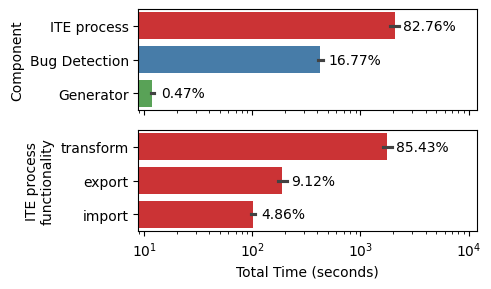

\newcommand{\TotTimeOneKProgramsFiveRoundsBugDetection}{420.91}
\newcommand{\TotTimeOneKProgramsFiveRoundsGenerator}{11.88}
\newcommand{\TotTimeOneKProgramsFiveRoundsITEprocess}{2077.36}
\newcommand{\TotTimeOneKProgramsFiveRoundsexport}{190.47}
\newcommand{\TotTimeOneKProgramsFiveRoundsimport}{101.13}
\newcommand{\TotTimeOneKProgramsFiveRoundstransform}{1785.76}
\newcommand{\AvgGeneratorTime}{0.00132}


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate total time spent in each component
component_time = df_time.groupby(['component', 'experiment_name'])[
    'time'].sum().reset_index()

# Calculate total time spent in each time_type

# keep only ITE Process component
df_time_only_ITE = df_time[df_time["component"] == "ITE process"]
time_type_time = df_time_only_ITE.groupby(['time_type', 'experiment_name'])[
    'time'].sum().reset_index()

# Create subplots
fig, axes = plt.subplots(
    2, 1, figsize=(5, 3),
    sharex=True,
    gridspec_kw={'height_ratios': [3, 3]})

# Plot histogram for total time spent in each component
sns.barplot(
    data=component_time.sort_values(by='time', ascending=False),
    x='time', y='component', ax=axes[0], hue="component",
    legend=False, palette='Set1')
axes[0].set_xlabel('Total Time (seconds)')
axes[0].set_ylabel('Component')
axes[0].set_xscale('log')

# Calculate total time
total_time = component_time['time'].sum() / len(EXPERIMENTS_COVERAGE)
max_time = component_time['time'].max()
# Add percentage labels on top of each bar
for p, component_label in zip(axes[0].patches, axes[0].get_yticklabels()):
    width = p.get_width()
    percentage = 100 * width / total_time
    axes[0].text(width * 1.2, p.get_y() + p.get_height() / 2,
                 f'{percentage:.2f}%', ha='left', va='center')
    component = ''.join(filter(str.isalpha, component_label.get_text()))
    print(
        f"\\newcommand{{\\PercentageTime{component}}}{{" + f"{percentage:.2f}\\%}}")
axes[0].set_xlim(right=max_time * 5)

# Plot histogram for total time spent in each time_type

# Map the names for better readability
time_type_time['time_type'] = time_type_time['time_type'].replace({
    'transformation_time': 'transform',
    'comparator_time': 'compare',
    'exporter_time': 'export',
    'importer_time': 'import',
    'conversion_time': 'convert',
    'generation_time': 'generate'
})
# keep only the functions in ITE process
time_type_time = time_type_time[time_type_time["time_type"].isin(
    ["transform", "export", "import"])]

sns.barplot(
    data=time_type_time.sort_values(by='time', ascending=False),
    x='time', y='time_type', ax=axes[1],
    legend=False, color=sns.color_palette('Set1')[0])
axes[1].set_xlabel('Total Time (seconds)')
axes[1].set_ylabel('ITE process\nfunctionality')
axes[1].set_xscale('log')

# Add percentage labels on top of each bar for time_type
total_time_type = time_type_time['time'].sum() / len(EXPERIMENTS_COVERAGE)
# print(f"Max time type: {max_time_type}")
for p, time_type_label in zip(axes[1].patches, axes[1].get_yticklabels()):
    width = p.get_width()
    percentage = 100 * width / total_time_type
    axes[1].text(width * 1.2, p.get_y() + p.get_height() / 2,
                 f'{percentage:.2f}%', ha='left', va='center')
    time_type = ''.join(filter(str.isalpha, time_type_label.get_text()))
    print(
        f"\\newcommand{{\\PercentageTime{time_type}}}{{" + f"{percentage:.2f}\\%}}")

plt.tight_layout()

fig.savefig('images/rq_time_distribution_sum_per_run.pdf')
plt.show()


# Calculate sum total time spent in each component
total_time_per_component = component_time.groupby(
    ['component', 'experiment_name'])['time'].sum().reset_index()
total_time_per_component = total_time_per_component.groupby('component')[
    'time'].mean().reset_index()

# Calculate sum total time spent in each time_type
total_time_per_time_type = time_type_time.groupby(
    ['time_type', 'experiment_name'])['time'].sum().reset_index()
total_time_per_time_type = total_time_per_time_type.groupby('time_type')[
    'time'].mean().reset_index()

# Print LaTeX commands for sum total time spent in each component
for _, row in total_time_per_component.iterrows():
    component = ''.join(filter(str.isalpha, row['component']))
    time = row['time']
    print(
        f"\\newcommand{{\\TotTimeOneKProgramsFiveRounds{component}}}{{{time:.2f}}}")

# Print LaTeX commands for sum total time spent in each time_type
for _, row in total_time_per_time_type.iterrows():
    time_type = ''.join(filter(str.isalpha, row['time_type']))
    time = row['time']
    print(
        f"\\newcommand{{\\TotTimeOneKProgramsFiveRounds{time_type}}}{{{time:.2f}}}")


# time to gnerate a program by generator
component_time = df_time.groupby(['component'])[
    'time'].mean()
avg_generator_time = component_time['Generator']
print(f"\\newcommand{{\\AvgGeneratorTime}}{{{avg_generator_time:.5f}}}")

In [41]:
from datetime import datetime
print("End of execution: ", datetime.now())

End of execution:  2025-03-14 12:53:42.016152
